In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

### 1️⃣ Data Loading & Initial Preprocessing

The Jena Climate dataset contains meteorological measurements recorded every **10 minutes** from 2009 to 2016.  
In this step, we:
- Load the raw CSV file and parse the datetime column.  
- Downsample the data to **hourly frequency** to remove redundancy.  
- Drop unused temperature columns (`Tpot (K)` and `Tdew (degC)`) but keep the timestamp for later feature engineering.  
- Perform quick sanity checks on shape and column consistency.

In [149]:
# -- Load the raw dataset (10-minute resolution) --
df = pd.read_csv('../data/Jena_Climate/jena_climate.csv')

In [150]:
df.shape

(420551, 15)

In [151]:
# -- Parse datetime column with explicit European format --
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [152]:
# -- Downsample to hourly frequency (keep only rows where minute == 0) --
# This reduces temporal redundancy while keeping daily patterns.
df = df[df['Date Time'].dt.minute == 0].reset_index(drop=True)

In [153]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [154]:
# -- Drop unused temperature-related columns --
# We'll keep 'Date Time' for time-based splits and feature engineering later.
df = df.drop(columns=['Tpot (K)', 'Tdew (degC)'])

In [155]:
# -- Quick preview after preprocessing --
print(f"Shape after hourly sampling: {df.shape}")
df.head()

Shape after hourly sampling: (70092, 13)


,Date Time,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


### 2️⃣ Exploring the Target Variable – Temperature

Before building any forecasting model, it’s important to visually inspect the target variable.  
Here, we plot the temperature (`T (degC)`) over time to understand its overall structure and dynamics.

**Observations:**
- Strong **annual seasonality** with clear cycles of warm and cold periods.  
- Short-term **daily fluctuations** within each season.  
- Slight long-term variations that might indicate slow climate trends or sensor drift.  

This confirms that our model will need to capture both **short-term** and **long-term** dependencies.

<Axes: title={'center': 'Temperature over Time (Hourly Data)'}, ylabel='°C'>

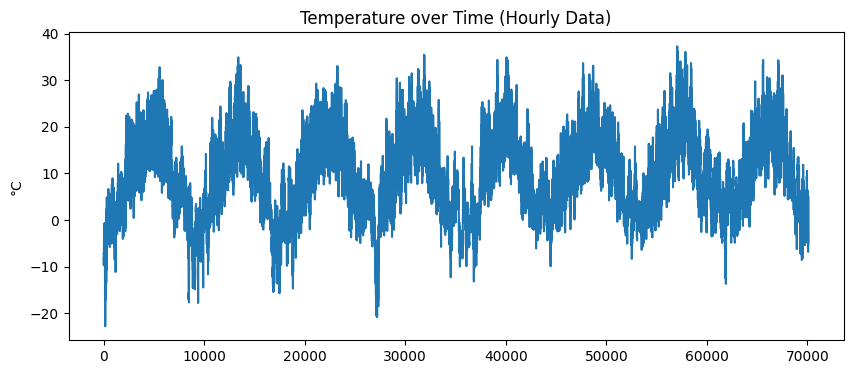

In [156]:
# -- Visualize the target variable: Temperature over time --
# This helps confirm seasonality patterns and variability levels.
temp = df["T (degC)"]
temp.plot(figsize=(10, 4), title="Temperature over Time (Hourly Data)", ylabel="°C")

### 3️⃣ Windowing, Chronological Split, and Scaling

We frame the forecasting task as: **use the last 7 days (168 hours) to predict the next 24 hours** of temperature.  
- **Window size (W)** = 168 (one week of hourly history).  
- **Horizon (H)** = 24 (next-day forecast).  
- We build rolling windows over the hourly data to obtain `(X, y)` pairs.  
- We then perform a **chronological split**: 80% train, 10% validation, 10% test.  
- **No leakage**: scalers are fitted **only on the training set**, then applied to val/test.  
- Shapes to expect:
  - `X`: `(N, 168, F)` with `F` input features
  - `y`: `(N, 24)` for the 24-hour target trajectory

In [157]:
# -- Forecasting setup --
# We use the last W=168 hours (7 days) to predict the next H=24 hours (1 day).
W = 240
H = 24

BATCH_SIZE = 64  # Training batch size
lr = 5e-4        # Learning rate (comment fixed: 5e-4, not 1e-3)
weight_decay = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -- Input/target descriptors --
# INPUT_SIZE counts all feature columns currently in df (we've kept 'Date Time' out already).
INPUT_SIZE = len(df.columns)
target = "T (degC)"

In [158]:
def df_to_window(df, W, H, target_col):
    """
    Build rolling windows:
    - X[i]  = df[i : i+W, :]
    - y[i]  = df[i+W : i+W+H, target_col]
    Returns:
        X: np.ndarray of shape (N, W, F)
        y: np.ndarray of shape (N, H)
    """
    X, y = [], []
    # Convert once to NumPy (float32 is friendlier for PyTorch)
    df_np = df.to_numpy(dtype=np.float32)

    # Iterate over all valid start indices
    for i in range(len(df) - W - H + 1):
        X.append(df_np[i:i+W, :])                 # (W, F)
        y.append(df_np[i+W:i+W+H, target_col])    # (H,)
    return np.array(X), np.array(y)

In [159]:
# -- Delete the DateTime column since we don't need it -- 
df = df.drop(columns=['Date Time'])

# -- Get the column index for the target ('T (degC)') --
index_target_col = df.columns.get_loc("T (degC)")

# -- Build the full windowed dataset (chronological order preserved) --
X_full, y_full = df_to_window(df, W, H, index_target_col)

# -- Quick shape check --
# X: (N, 168, F), y: (N, 24)
print(X_full.shape, y_full.shape)

(69829, 240, 12) (69829, 24)


In [160]:
# -- Chronological split: 80% train, 10% val, 10% test --
tot_len = X_full.shape[0]
train_len = int(tot_len * 0.8)
valid_len = int(tot_len * 0.1)

X_train, y_train = X_full[:train_len], y_full[:train_len]
X_valid, y_valid = X_full[train_len:train_len+valid_len], y_full[train_len:train_len+valid_len]
X_test,  y_test  = X_full[train_len+valid_len:],          y_full[train_len+valid_len:]

# Sanity check on shapes
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55863, 240, 12),
 (55863, 24),
 (6982, 240, 12),
 (6982, 24),
 (6984, 240, 12),
 (6984, 24))

In [161]:
# -- Standardize features and target using train-only statistics to avoid leakage --
scX, scY = StandardScaler(), StandardScaler()

# X: (N, W, F) -> (N*W, F) for fitting; reshape back afterwards
Xtr = scX.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
Xva = scX.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
Xte = scX.transform(X_test.reshape(-1,  X_test.shape[-1])).reshape(X_test.shape)

# y: (N, H) -> (N*H, 1) for fitting; reshape back afterwards
ytr = scY.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
yva = scY.transform(y_valid.reshape(-1, 1)).reshape(y_valid.shape)
yte = scY.transform(y_test.reshape(-1,  1)).reshape(y_test.shape)

# Optional sanity checks (uncomment if you want quick assertions):
assert np.isclose(Xtr.mean(), 0, atol=1e-2) and np.isclose(Xtr.std(), 1, atol=1e-2)
assert np.isclose(ytr.mean(), 0, atol=1e-2) and np.isclose(ytr.std(), 1, atol=1e-2)

In [162]:
Xtr.shape, ytr.shape, Xva.shape, yva.shape, Xte.shape, yte.shape

((55863, 240, 12),
 (55863, 24),
 (6982, 240, 12),
 (6982, 24),
 (6984, 240, 12),
 (6984, 24))

### 4️⃣ PyTorch Datasets & DataLoaders

We convert the windowed numpy arrays into PyTorch tensors and build DataLoaders:

- `TensorDataset(X, y)` pairs each input window `(W, F)` with its multi-step target `(H,)`.
- `shuffle=True` only for the **training** set to break temporal locality within batches.
- `pin_memory=True` is useful when moving data to GPU (speeds up host-to-device transfers).
- We keep `num_workers=0` (Windows/lightweight setup); increase if CPU I/O becomes a bottleneck.
- Optional: `drop_last=True` for the training loader to keep batch sizes consistent.

In [163]:
# -- Convert numpy arrays to float32 tensors --
X_train_t = torch.tensor(Xtr, dtype=torch.float32)
y_train_t = torch.tensor(ytr, dtype=torch.float32)

X_valid_t = torch.tensor(Xva, dtype=torch.float32)
y_valid_t = torch.tensor(yva, dtype=torch.float32)

X_test_t  = torch.tensor(Xte, dtype=torch.float32)
y_test_t  = torch.tensor(yte, dtype=torch.float32)
    

# -- Wrap into TensorDatasets --
train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)


# -- Build DataLoaders --
# shuffle=True only for train; pin_memory helps GPU transfers; drop_last optional for stable batch sizes
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,num_workers=0, pin_memory=True)

In [164]:
# -- Quick sanity check: one batch --
xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)     # Expected: (B, 168, F) and (B, 24)

torch.Size([64, 240, 12]) torch.Size([64, 24])


### 5️⃣ LSTM Forecaster (7-day context → 24-hour forecast)

We use a stacked LSTM to encode the last **W=168** hours.  
A lightweight readout head (Linear → GELU → Dropout → Linear) maps the sequence
embedding to a **24-dimensional** output (multi-step forecast for the next day).

Design choices:
- **Temporal pooling**: mean over the last **K** steps (default `K=8`) to stabilize the readout.
- **Bidirectionality** is disabled to avoid peeking into the future (strict causal setting).
- **Dropout** is only applied between LSTM layers (PyTorch) and in the MLP head.

In [165]:
class Predictor(nn.Module):
    def __init__(
        self,
        input_dim,              # number of input features (F)
        hidden_dim=128,         # LSTM hidden size per direction
        num_layers=2,           # stacked LSTM layers
        output_dim=24,          # multi-step horizon (24 hours)
        dropout=0.3,            # LSTM inter-layer dropout (if num_layers > 1)
        K=8,                    # pool over the last K time steps
        bidirectional=False     # keep False to avoid look-ahead (causality)
    ):
        super().__init__()
        self.K = K

        # LSTM outputs (B, T, feat) with feat = hidden_dim * (2 if bidir else 1)
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )
        feat = hidden_dim * (2 if bidirectional else 1)

        # MLP readout head: feat -> (feat//2, >=32) -> output_dim
        mid = max(32, feat // 2)
        self.fc1 = nn.Linear(feat, mid)
        self.fc2 = nn.Linear(mid, output_dim)
        self.dropout = nn.Dropout(0.1)

        # Initialize the final layer a bit smaller for stability
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.5)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """
        x: (B, T, F) where T = 168 and F = input_dim
        returns: (B, 24)
        """
        # Speed-up for CuDNN LSTM on contiguous params
        self.lstm.flatten_parameters()

        out, _ = self.lstm(x)          # (B, T, feat)

        # Mean-pool over the last K time steps (robust vs. last-step noise)
        k = min(self.K, out.size(1))
        out = out[:, -k:, :].mean(dim=1)   # (B, feat)

        # Readout head
        out = F.gelu(self.fc1(out))        # (B, mid)
        out = self.dropout(out)
        out = self.fc2(out)                # (B, 24)
        return out

### 6️⃣ Training & Evaluation Loops

We train the LSTM forecaster with mini-batches and evaluate on a held-out
validation set:

- **Loss**: MAE (L1) or MSE on **standardized targets** (no leakage).
- **Averaging**: losses are accumulated *per sample* to avoid batch-size bias.
- **Best model**: we track the lowest validation loss and keep the corresponding weights.
- **Stability**: light gradient clipping prevents rare exploding updates.
- **Reproducibility**: fixed seeds and deterministic cuDNN where applicable.

In [ ]:
def train(model, train_loader, optimizer, loss_fn, device=DEVICE, max_grad_norm=1.0):
    """
    One full training epoch.
    - Accumulates loss per-sample to compute an epoch average.
    - Applies light gradient clipping for stability.
    """
    model.train()
    epoch_loss_sum = 0.0
    epoch_num_samples = 0

    for X, y in train_loader:
        # Move batch to device
        X = X.to(device=device, non_blocking=True)
        y = y.to(device=device, non_blocking=True)

        # Standard training step
        optimizer.zero_grad(set_to_none=True)
        pred = model(X)                  # forward
        loss = loss_fn(pred, y)          # scalar loss on standardized scale
        loss.backward()                  # backward

        # Gradient clipping (1.0)
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Accumulate loss *per-sample* to average correctly at epoch end
        bs = X.size(0)
        epoch_loss_sum += loss.item() * bs
        epoch_num_samples += bs

    # Average epoch loss
    return epoch_loss_sum / max(epoch_num_samples, 1)


def evaluate(model, loader, loss_fn, device=DEVICE):
    """
    Evaluation loop (no gradient) and model in evaluation mode. Returns the average loss per sample.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, non_blocking=True)
            y = y.to(device=device, non_blocking=True)

            output = model(X)
            val_loss = loss_fn(output, y)

            bs = X.size(0)
            total_loss += val_loss.item() * bs
            total_samples += bs

    return total_loss / max(total_samples, 1)  # mean loss over the dataset

In [167]:
def eval_mae_rmse_celsius(model, loader, scY, device=DEVICE):
    """
    Compute MAE/RMSE in physical units (°C) by inverse transforming the targets.
    """
    model.eval()
    abs_err, sq_err, n = 0.0, 0.0, 0

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device); y = y.to(device)
            y_hat_std = model(X)                            # (B, H)
            # back to numpy for inverse scaling
            y_hat = scY.inverse_transform(y_hat_std.cpu().numpy().reshape(-1,1)).reshape(-1, y.shape[1])
            y_true = scY.inverse_transform(y.cpu().numpy().reshape(-1,1)).reshape(-1, y.shape[1])

            diff = y_hat - y_true                           # (B, H)
            abs_err += np.abs(diff).sum()
            sq_err  += (diff**2).sum()
            n       += diff.size

    mae  = abs_err / n
    rmse = np.sqrt(sq_err / n)
    return mae, rmse


### 7️⃣ Optimization Setup & Training Loop


We train the LSTM forecaster with **AdamW** and monitor validation loss with
**ReduceLROnPlateau**. We keep the **best checkpoint** (lowest val loss) and use
**early stopping** to prevent overfitting.

- **Loss**: MSE on standardized targets (stable and smooth for multi-step).
- **Scheduler**: halve the LR after a patience of 2 epochs without improvement.
- **Early stopping**: stop after 10 bad epochs.
- **Metrics**: we also report validation **MAE/RMSE in °C** (inverse-scaled) per epoch.

In [168]:
# -- Model / optimizer / loss / scheduler --
input_dim = X_train_t.shape[-1]
model = Predictor(input_dim=input_dim, hidden_dim=64, num_layers=2, output_dim=H).to(device=DEVICE)
loss_fn   = nn.MSELoss()  # training loss on standardized scale
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Plateau scheduler: reduce LR when val loss stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=2, min_lr=1e-6)

In [169]:
# Training configuration
EPOCHS   = 50
patience = 10  # early stopping patience
bad      = 0

best_val   = float("inf")
best_state = None
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    # --- Training and validation ---
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_loss   = evaluate(model, valid_loader, loss_fn)
    scheduler.step(val_loss)

    # -- Evaluate physical-scale metrics (in °C) --
    val_mae_c, val_rmse_c = eval_mae_rmse_celsius(model, valid_loader, scY)

    # --- Track the best model ---
    if val_loss < best_val:
        best_val   = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_epoch = epoch
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print(f"Early stop at epoch {epoch}. Best val={best_val:.4f} (epoch {best_epoch})")
            break

    # --- Log training progress ---
    print(f"Epoch {epoch} | Train={train_loss:.4f} | Val={val_loss:.4f} "
          f"| MAE°C={val_mae_c:.3f} | RMSE°C={val_rmse_c:.3f} | LR={optimizer.param_groups[0]['lr']:.2e}")

# --- Restore best checkpoint ---
model.load_state_dict(best_state)
model.to(DEVICE)

Epoch 1 | Train=0.2156 | Val=0.1301 | MAE°C=2.324 | RMSE°C=3.017 | LR=5.00e-04
Epoch 2 | Train=0.1171 | Val=0.1213 | MAE°C=2.251 | RMSE°C=2.913 | LR=5.00e-04
Epoch 3 | Train=0.1075 | Val=0.1093 | MAE°C=2.127 | RMSE°C=2.765 | LR=5.00e-04
Epoch 4 | Train=0.1007 | Val=0.1069 | MAE°C=2.114 | RMSE°C=2.735 | LR=5.00e-04
Epoch 5 | Train=0.0954 | Val=0.1048 | MAE°C=2.082 | RMSE°C=2.707 | LR=5.00e-04
Epoch 6 | Train=0.0918 | Val=0.1045 | MAE°C=2.068 | RMSE°C=2.705 | LR=5.00e-04
Epoch 7 | Train=0.0880 | Val=0.1044 | MAE°C=2.069 | RMSE°C=2.703 | LR=5.00e-04
Epoch 8 | Train=0.0848 | Val=0.1061 | MAE°C=2.093 | RMSE°C=2.724 | LR=5.00e-04
Epoch 9 | Train=0.0817 | Val=0.1017 | MAE°C=2.041 | RMSE°C=2.667 | LR=5.00e-04
Epoch 10 | Train=0.0784 | Val=0.1007 | MAE°C=2.035 | RMSE°C=2.655 | LR=5.00e-04
Epoch 11 | Train=0.0753 | Val=0.1082 | MAE°C=2.104 | RMSE°C=2.751 | LR=5.00e-04
Epoch 12 | Train=0.0724 | Val=0.1121 | MAE°C=2.137 | RMSE°C=2.801 | LR=5.00e-04
Epoch 13 | Train=0.0692 | Val=0.1054 | MAE°C=2.08

Predictor(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=24, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Training converged quickly with the best validation loss around **epoch 10**, followed by a mild
overfitting trend. The best validation MAE is ~**2°C**, which is promising.  
To contextualize this, we compare against a **persistence baseline** (tomorrow's temperature equals
today's at the same hour) and then report final **test** metrics.

### 8️⃣ Test Set Performance vs. Persistence Baseline

In [170]:
# -- Persistence baseline --
# For each (X,y), the baseline predicts that the next 24h equal the last 24h observed.
# That is, for horizon h=1..24, y_hat[:, h] = X[:, -24 + (h-1), target_feature]

def persistence_baseline_mae_rmse(X, y, target_idx, scY):
    """
    X: (N, W, F)    standardized features
    y: (N, H)       standardized targets (or physical if scY is None)
    target_idx: int index of target column in X
    scY: StandardScaler fitted on y (for inverse-transform to °C)

    Returns: (MAE°C, RMSE°C)
    """
    # Take the last 24 time steps of the target feature from X as prediction
    last_24 = X[:, -y.shape[1]:, target_idx]             # (N, H) on standardized feature scale

    # Bring both true labels and predicted labels to °C for human-readable metrics
    y_true = scY.inverse_transform(y.reshape(-1,1)).reshape(y.shape)
    # We must map the standardized *feature* back to target scale too:
    y_hat  = scY.inverse_transform(last_24.reshape(-1,1)).reshape(last_24.shape)


    diff = y_hat - y_true
    mae  = np.abs(diff).mean()
    rmse = np.sqrt((diff**2).mean())
    return mae, rmse

target_idx = index_target_col  # already computed earlier

val_p_mae,  val_p_rmse  = persistence_baseline_mae_rmse(Xva, yva, target_idx, scY)
test_p_mae, test_p_rmse = persistence_baseline_mae_rmse(Xte, yte, target_idx, scY)

print(f"Persistence (VAL)  → MAE={val_p_mae:.3f}°C | RMSE={val_p_rmse:.3f}°C")
print(f"Persistence (TEST) → MAE={test_p_mae:.3f}°C | RMSE={test_p_rmse:.3f}°C")

Persistence (VAL)  → MAE=2.806°C | RMSE=3.655°C
Persistence (TEST) → MAE=2.368°C | RMSE=3.079°C


In [171]:
# Final evaluation with the best checkpoint already loaded
test_mae_c, test_rmse_c = eval_mae_rmse_celsius(model, test_loader, scY)
print(f"Model (TEST) → MAE={test_mae_c:.3f}°C | RMSE={test_rmse_c:.3f}°C")

Model (TEST) → MAE=1.792°C | RMSE=2.339°C


We compare the LSTM forecaster against a persistence baseline (tomorrow’s temperature
equals today’s at the same hour):

- **Baseline (TEST)** — MAE: 2.369 °C, RMSE: 3.080 °C  
- **Model (TEST)** — MAE: 1.792 °C, RMSE: 2.339 °C  

**Result:** The model improves over persistence by **~25% MAE** and **~25% RMSE** on the test set, 
which indicates meaningful predictive skill beyond seasonal repetition.
